<a href="https://colab.research.google.com/github/timsetsfire/odsc-ml-drum/blob/main/Colab%20-%20Graph%20Isomorphism%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%sh
git clone https://github.com/timsetsfire/odsc-ml-drum.git
pip install -r /content/odsc-ml-drum/src/other_models/imdb_gin/requirements.txt -q

Cloning into 'odsc-ml-drum'...
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# Wild Mode - IMDB Graph Classification

[How Powerful are Graph Neural Networks](https://arxiv.org/pdf/1810.00826v3.pdf)

## IMDB Binary Dataset

Each record in our dataset is a graph, specifically, a genre graph.  Each genre graph can be either an action genre graph, or a romance genre graph and the task is to classify the genre graph.  The vertices in a given genre graph represent the actors and actresses who appear in the movies composing the particular genre graph, and and edge is drawn between two actors/actresses if they appear in the same movie.  Unfortunately, details on the dataset are pretty sparse.  


## Graph Isomorphism

The graph isomorphism problem asks whether two graphs are topologically
identical, and the Graph Isomorpshism Network is a means find a representation of a graph in an embedding space.  The model was trained with the [Deep Graph Library](https://github.com/dmlc/dgl), specifically, the [GIN](https://github.com/dmlc/dgl/blob/master/examples/pytorch/gin/gin.py) example.

## Data

We'll parse the data to a list of graphs, and serialize the data using avro.  For serialization, we could have used
* straight json
* serialize networkx graph objects
* serialize the dgl graph object

Avro has a JSON like data model, but can be represented as either JSON or in a compact binary form.

* It comes with a very sophisticated schema description language that describes data.
* It has a direct mapping to and from JSON.
* It has a very compact format.
* The bulk of JSON, repeating every field name with every single record, is what makes JSON inefficient for high-volume usage

The sophisticated schema description can provide a sort of validation of the data, requiring types of data elements.

In [1]:
import io
import networkx as nx
from pprint import pprint
import subprocess
import sys
sys.path.append("/content/odsc-ml-drum/src/other_models/imdb_gin")
from score_data import * 

# Prepare the data

The data came by way of three files: edges, nodes, and labels and can be [downloaded](http://networkrepository.com/IMDB-BINARY.php) from the [network repository](http://networkrepository.com)

In [2]:
%%sh
curl http://nrvis.com/download/data/labeled/IMDB-BINARY.zip > IMDB-BINARY.zip
unzip IMDB-BINARY.zip

Archive:  IMDB-BINARY.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  553k  100  553k    0     0   299k      0  0:00:01  0:00:01 --:--:--  299k
replace IMDB-BINARY.edges? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [2]:
with open("IMDB-BINARY.edges", "r") as f:
    edges = [r.strip("\n") for r in f.readlines()]
with open("IMDB-BINARY.graph_idx", "r") as f:
    index = [r.strip("\n") for r in f.readlines()]
with open("IMDB-BINARY.graph_labels", "r") as f:
    labels = [int(r.strip("\n")) for r in f.readlines()]

edges = [e.split(",") for e in edges]
edges = [ [int(i)-1 for i in e] for e in edges]
index = [int(i)-1 for i in index]
labels = dict(zip( range(0,len(labels)), labels))

indexed_nodes = list(zip(index, range(0, len(index))))

graphs = {}
for i in range(0,1000):
    graphs[i] = {"vertices": [], "edges": []}
    graphs[i]["idx"] = i

for i, n in indexed_nodes:
    graphs[i]["vertices"].append(n)
nodes_2_graphs = {}
for i, n in indexed_nodes:
    nodes_2_graphs[n] = i   
for edge in edges:
    graph_membership = nodes_2_graphs[edge[0]]
    if edge in graphs[graph_membership]["edges"]:
        pass
    else:
        graphs[graph_membership]["edges"].append(edge)
## optional to add labels, nothing is done with them
for k,v in labels.items():
    graphs[k]["label"] = v
graphs = list(graphs.values())

## Visualize a few graphs

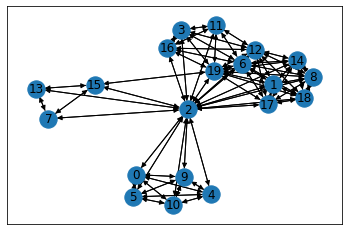

In [3]:
g0 = nx.DiGraph()
g0.add_edges_from(graphs[0]["edges"])
nx.draw_networkx(g0)

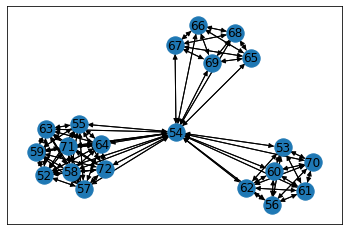

In [4]:
g0 = nx.DiGraph()
g0.add_edges_from(graphs[2]["edges"])
nx.draw_networkx(g0)

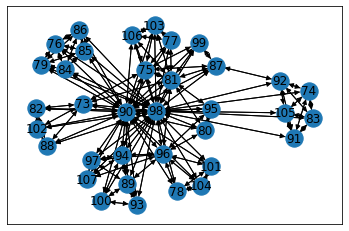

In [5]:
g0 = nx.DiGraph()
g0.add_edges_from(graphs[3]["edges"])
nx.draw_networkx(g0)

## Start inference server in unstructured mode

In [6]:
run_server = [
    "drum", "server",
    "--code-dir", "/content/odsc-ml-drum/src/other_models/imdb_gin",
    "--address", "localhost:1234",
    "--target-type", "unstructured",
    "--verbose", 
    "--logging-level", "info"]
inference_server = subprocess.Popen(run_server, stdout=subprocess.PIPE)

In [7]:
import time
time.sleep(5)

In [8]:
schema = load_schema("/content/odsc-ml-drum/src/other_models/imdb_gin/schema_graph.avsc")
pprint(schema.to_json())

{'fields': [{'name': 'index', 'type': 'int'},
            {'name': 'edges',
             'type': [{'default': [],
                       'items': {'default': [],
                                 'items': 'int',
                                 'type': 'array'},
                       'type': 'array'},
                      'null']},
            {'name': 'vertices',
             'type': [{'default': [], 'items': 'int', 'type': 'array'},
                      'null']},
            {'name': 'label', 'type': ['int', 'null']},
            {'name': 'edge_features',
             'type': [{'default': [],
                       'items': {'default': [],
                                 'items': 'float',
                                 'type': 'array'},
                       'type': 'array'},
                      'null']},
            {'name': 'vertex_features',
             'type': [{'default': [],
                       'items': {'default': [],
                                 'items': 'floa

## Score Graphs

In [9]:
out = score(graphs[0:10], schema, "http://localhost", "1234")

In [14]:
import numpy as np
np.round(pd.DataFrame(out.json()), 3)

,neg_class,pos_class
0,1.000,0.000
1,1.000,0.000
2,0.431,0.569
3,1.000,0.000
4,0.000,1.000
5,1.000,0.000
6,0.000,1.000
7,0.000,1.000
8,0.000,1.000
9,0.000,1.000


In [15]:
import requests
requests.post("http://localhost:1234/shutdown").content

b'Server shutting down...'